In [469]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.nn.functional as F


In [470]:
class Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        inputs, labels = sample[0], sample[1]

        if self.transform:
            inputs = self.transform(inputs)
        return inputs, labels


In [471]:
batch_size = 32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset = Dataset(mnist_trainset)
test_dataset = Dataset(mnist_testset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


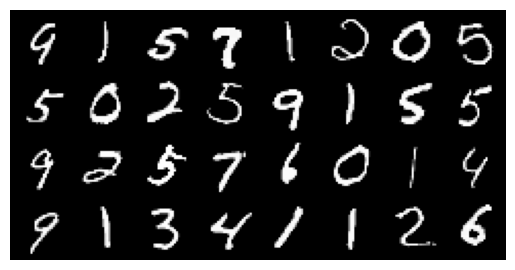

In [472]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


sample = next(iter(train_loader))
images, labels = sample
grid_img = vutils.make_grid(images, nrow=8)
grid_img_np = grid_img.numpy()
grid_img_np = np.transpose(grid_img_np, (1, 2, 0))
plt.imshow(grid_img_np)
plt.axis('off')  
plt.show()



In [473]:
class SNN(nn.Module):
   def __init__(self, input_dim=784, output_dim=10):
      super(SNN, self).__init__()
      self.l1 = nn.Linear(input_dim, 256)
      self.l2 = nn.Linear(256, 128)
      self.l3 = nn.Linear(128, 64)
      self.l4 = nn.Linear(64, 32)
      self.l5 = nn.Linear(32, output_dim)
   
   def forward(self, x):
      x = F.relu(self.l1(x))
      x = F.relu(self.l2(x))
      x = F.relu(self.l3(x))
      x = F.relu(self.l4(x))
      x = F.softmax(self.l5(x), dim=1)
      return x


In [474]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [475]:
model = SNN().to(device)
model

SNN(
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=32, bias=True)
  (l5): Linear(in_features=32, out_features=10, bias=True)
)

In [476]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [477]:
def train_model(model, train_loader, criterion, optimizer, device='cuda', NUM_EPOCHS=32):

    model.train()  
    model.to(device)
    criterion.to(device)

    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0.0
        num_batches = len(train_loader)

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            y_pred = model(inputs)

            loss = criterion(y_pred, labels)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        

        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}] Loss: {loss:.4f}')

    print('Training completed.')



train_model(model, train_loader, criterion, optimizer)


Epoch [1/32] Loss: 1.4900
Epoch [2/32] Loss: 1.6169
Epoch [3/32] Loss: 1.5027
Epoch [4/32] Loss: 1.6611
Epoch [5/32] Loss: 1.4924
Epoch [6/32] Loss: 1.4612
Epoch [7/32] Loss: 1.4989
Epoch [8/32] Loss: 1.4612
Epoch [9/32] Loss: 1.4924
Epoch [10/32] Loss: 1.4925
Epoch [11/32] Loss: 1.5549
Epoch [12/32] Loss: 1.5240
Epoch [13/32] Loss: 1.5862
Epoch [14/32] Loss: 1.4924
Epoch [15/32] Loss: 1.5236
Epoch [16/32] Loss: 1.5237
Epoch [17/32] Loss: 1.4612
Epoch [18/32] Loss: 1.5237
Epoch [19/32] Loss: 1.4924
Epoch [20/32] Loss: 1.6174
Epoch [21/32] Loss: 1.5549
Epoch [22/32] Loss: 1.5549
Epoch [23/32] Loss: 1.4924
Epoch [24/32] Loss: 1.7112
Epoch [25/32] Loss: 1.4932
Epoch [26/32] Loss: 1.5862
Epoch [27/32] Loss: 1.4612
Epoch [28/32] Loss: 1.6173
Epoch [29/32] Loss: 1.4924
Epoch [30/32] Loss: 1.5862
Epoch [31/32] Loss: 1.5861
Epoch [32/32] Loss: 1.5549
Training completed.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            #inputs = inputs.view(inputs.size(0), -1)
            preds = model(inputs)

            _, predicted_labels = torch.max(preds, 1)

            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

In [ ]:
evaluate_model(model, test_loader, device='cuda')

Test Accuracy: 0.9661
Test Precision: 0.9670
Test Recall: 0.9661
Test F1 Score: 0.9661


In [ ]:
class SCNN(nn.Module):
    def __init__(self, input_channels=1, output_dim=10):  
        super(SCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(16 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x


In [ ]:
model = SCNN().to(device)
model

SCNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device='cuda', NUM_EPOCHS=64):

    model.train()  
    model.to(device)
    criterion.to(device)

    

    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0.0
        num_batches = len(train_loader)

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)

            loss = criterion(y_pred, labels)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()


        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}] Loss: {loss:.4f}')

    print('Training completed.')



train_model(model, train_loader, criterion, optimizer)

Epoch [1/64] Average Loss: 1.7541
Epoch [2/64] Average Loss: 1.5998
Epoch [3/64] Average Loss: 1.5880
Epoch [4/64] Average Loss: 1.5545
Epoch [5/64] Average Loss: 1.4971
Epoch [6/64] Average Loss: 1.4921
Epoch [7/64] Average Loss: 1.4894
Epoch [8/64] Average Loss: 1.4877
Epoch [9/64] Average Loss: 1.4863
Epoch [10/64] Average Loss: 1.4853
Epoch [11/64] Average Loss: 1.4842
Epoch [12/64] Average Loss: 1.4827
Epoch [13/64] Average Loss: 1.4828
Epoch [14/64] Average Loss: 1.4828
Epoch [15/64] Average Loss: 1.4823
Epoch [16/64] Average Loss: 1.4834
Epoch [17/64] Average Loss: 1.4821
Epoch [18/64] Average Loss: 1.4825
Epoch [19/64] Average Loss: 1.4822
Epoch [20/64] Average Loss: 1.4808
Epoch [21/64] Average Loss: 1.4818
Epoch [22/64] Average Loss: 1.4831
Epoch [23/64] Average Loss: 1.4834
Epoch [24/64] Average Loss: 1.4830
Epoch [25/64] Average Loss: 1.4818
Epoch [26/64] Average Loss: 1.4835
Epoch [27/64] Average Loss: 1.4823
Epoch [28/64] Average Loss: 1.4817
Epoch [29/64] Average Loss: 1

In [ ]:
evaluate_model(model, test_loader, device='cuda')

Test Accuracy: 0.9647
Test Precision: 0.9664
Test Recall: 0.9647
Test F1 Score: 0.9649
